In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import random
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
import keras
from keras.models import load_model 
from keras import optimizers
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [7]:
# Read tsv file as csv
data = pd.read_csv('C:\\Users\\or.hirshman\\Documents\\\learning\\DS_Projects\\similarweb\\DQ_Data_b.tsv', sep='\t')

In [8]:
data.head()

,source,site,% U,V
0,0,06880danwoog.com*,3.343111e-06,36280.0
1,0,0800-horoscope.com*,1.075026e-05,120690.0
2,0,10000boatnames.com*,5.871362e-07,6858.0
3,0,100bestvacations.com*,1.516845e-06,12891.0
4,0,100stuartstreet.com*,1.128228e-06,9758.0


In [9]:
data.info()
# We have 28364 entries, and 4 columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28364 entries, 0 to 28363
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   source  28364 non-null  int64  
 1   site    28364 non-null  object 
 2   % U     28364 non-null  float64
 3   V       28364 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 886.5+ KB


In [10]:
data.describe()

,source,% U,V
count,28364.000000,2.836400e+04,2.836400e+04
mean,1.136723,1.278015e-04,1.337023e+06
std,1.021121,3.093624e-03,3.460400e+07
min,0.000000,1.045405e-07,1.020107e+03
25%,0.000000,2.165681e-06,2.085839e+04
50%,1.000000,7.001150e-06,6.868358e+04
75%,2.000000,3.019798e-05,3.009082e+05
max,3.000000,4.345977e-01,4.872713e+09


In [11]:
# Check for Nulls
data.isnull().sum()

#There ane no Nulls for all entries

source    0
site      0
% U       0
V         0
dtype: int64

In [12]:
# How many unique sites are in the dataset?
len(data.site.unique())

9699

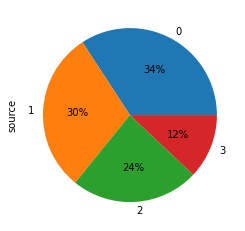

In [13]:
#Pie chart for all source types
data['source'].value_counts().plot(kind='pie', autopct='%1.0f%%')

#More than 1\3 of the data is in the learning set, 30% are in source 1, 24% in source 2, 12% in source 3

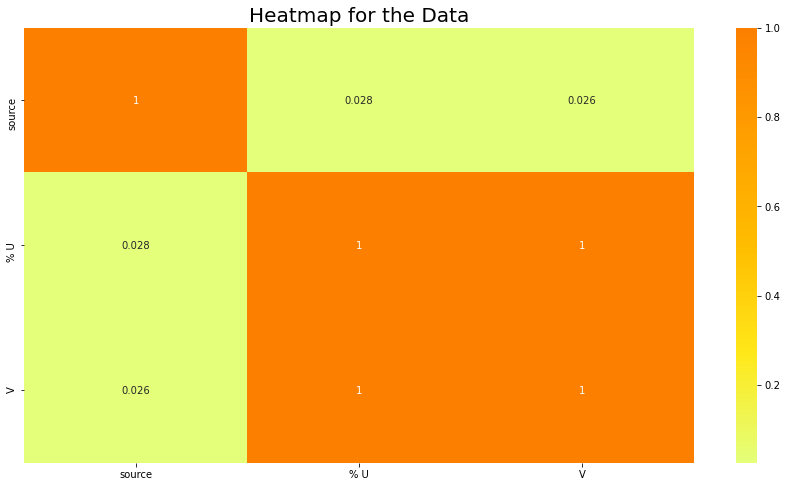

In [14]:
# Heatmap
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

In [26]:
# Create a separate dataframe for each data source

data0 = data[data['source'] == 0]
data1 = data[data['source'] == 1]
data2 = data[data['source'] == 2]
data3 = data[data['source'] == 3]

In [90]:
display(data0)
display(data1)
display(data2)
display(data3)

# We can see that each dataset does not contain the same sites as the learning set

,source,site,% U,V
0,0,06880danwoog.com*,3.343111e-06,36280.0
1,0,0800-horoscope.com*,1.075026e-05,120690.0
2,0,10000boatnames.com*,5.871362e-07,6858.0
3,0,100bestvacations.com*,1.516845e-06,12891.0
4,0,100stuartstreet.com*,1.128228e-06,9758.0
...,...,...,...,...
9694,0,zurinstitute.com*,3.216422e-06,28788.0
9695,0,zvents.com*,9.387970e-05,740008.0
9696,0,zx6r.com*,4.094824e-06,57444.0
9697,0,zybez.net*,7.628508e-05,1237033.0


,source,site,% U,V
9699,1,06880danwoog.com*,5.064813e-06,7.450894e+04
9700,1,0800-horoscope.com*,7.976695e-06,8.851447e+04
9701,1,10000boatnames.com*,7.662127e-07,7.476707e+03
9702,1,100bestvacations.com*,1.083000e-06,1.056819e+04
9703,1,100stuartstreet.com*,1.919115e-06,1.872674e+04
...,...,...,...,...
18196,1,zurinstitute.com*,4.737790e-06,4.846192e+04
18197,1,zvents.com*,1.431665e-04,1.444088e+06
18198,1,zx6r.com*,4.790944e-06,4.675006e+04
18199,1,zybez.net*,1.081722e-04,1.474000e+06


,source,site,% U,V
18201,2,06880danwoog.com*,8.672000e-06,7.752445e+04
18202,2,0800-horoscope.com*,1.928600e-05,1.724088e+05
18203,2,1015store.com*,4.035164e-05,3.607274e+05
18204,2,101kgb.com*,1.440644e-05,1.287878e+05
18205,2,101science.com*,6.500000e-07,5.810537e+03
...,...,...,...,...
24945,2,ztgd.com*,2.039424e-06,1.823163e+04
24946,2,zvents.com*,8.486724e-05,7.973462e+05
24947,2,zx6r.com*,8.230597e-06,7.357822e+04
24948,2,zybez.net*,1.244973e-04,1.326869e+06


,source,site,% U,V
24950,3,0800-horoscope.com*,8.793715e-06,74442.341462
24951,3,1015store.com*,1.348858e-05,129225.542762
24952,3,101kgb.com*,1.299100e-05,109974.414664
24953,3,101science.com*,8.284027e-07,7012.763234
24954,3,1035kissfm.com*,1.373429e-05,116266.284138
...,...,...,...,...
28359,3,zonebourse.com*,1.156759e-06,11197.604024
28360,3,zoochat.com*,3.372321e-06,28548.056223
28361,3,zvents.com*,8.083042e-05,684262.095167
28362,3,zybez.net*,9.802633e-05,923140.202379


In [33]:
# Describe each dataframe
display(data0.describe())
display(data1.describe())
display(data2.describe())
display(data3.describe())

,source,% U,V
count,9699.0,9.699000e+03,9.699000e+03
mean,0.0,6.249331e-05,6.493156e+05
std,0.0,4.802266e-04,5.558451e+06
min,0.0,2.790000e-07,5.001000e+03
25%,0.0,1.486785e-06,1.424450e+04
50%,0.0,4.236642e-06,4.119500e+04
75%,0.0,1.697491e-05,1.731955e+05
max,0.0,2.085859e-02,2.619745e+08


,source,% U,V
count,8502.0,8.502000e+03,8.502000e+03
mean,1.0,7.291470e-05,8.054732e+05
std,0.0,6.688866e-04,7.577127e+06
min,1.0,1.045405e-07,1.020107e+03
25%,1.0,1.660861e-06,1.715018e+04
50%,1.0,4.944889e-06,5.204454e+04
75%,1.0,1.875423e-05,2.008795e+05
max,1.0,3.308058e-02,3.713884e+08


,source,% U,V
count,6749.0,6.749000e+03,6.749000e+03
mean,2.0,1.779296e-04,1.831009e+06
std,0.0,1.476425e-03,1.643595e+07
min,2.0,3.550000e-07,3.173740e+03
25%,2.0,4.893127e-06,4.531102e+04
50%,2.0,1.532759e-05,1.429922e+05
75%,2.0,5.589029e-05,5.349521e+05
max,2.0,6.195002e-02,6.937006e+08


,source,% U,V
count,3414.0,3.414000e+03,3.414000e+03
mean,3.0,3.509293e-04,3.637961e+06
std,0.0,8.566195e-03,9.580350e+07
min,3.0,2.190000e-07,1.854112e+03
25%,3.0,4.115380e-06,3.595316e+04
50%,3.0,1.758527e-05,1.556398e+05
75%,3.0,7.005734e-05,6.235831e+05
max,3.0,4.345977e-01,4.872713e+09


In [ ]:
# Comparison between learning set and source1:
#It seems that by all paramters (mean, std, min, 25%, 50%, 75%, max) the values of both V and %U in the learning set
# and source1 are quite similar and in the same scale

# Comparison between learning set and source2:
#It seems that for most of the paramters (min, 25%, 75%, max) the values of both V and %U in the learning set
# and source2 are quite similar and in the same scale, for the other parameters (mean, std, 50%) there is
# a difference of *10 for both V and %U 

# Comparison between learning set and source3:
#It seems that for some of the paramters (min, 25%, 75%) the values of both V and %U in the learning set
# and source2 are quite similar and in the same scale, for most of the parameters (mean, std, 50%, max) there is
# a difference of *10 for both V and %U 

In [93]:
# Check if each of the sources (1-3) contains sites which are not in the learning set
arr_data0 = data0['site'].to_numpy()
arr_data1 = data1['site'].to_numpy()
arr_data2 = data2['site'].to_numpy()
arr_data3 = data3['site'].to_numpy()

display(np.setdiff1d(arr_data1, arr_data0))
display(np.setdiff1d(arr_data2, arr_data0))
display(np.setdiff1d(arr_data3, arr_data0))

# The learning set contains all the sites which are in each source (1-3)

array([], dtype=object)

array([], dtype=object)

array([], dtype=object)

In [94]:
# Check if the learning set contains items which are not in the sources (1-3),
# and check if those items are the same for each source

display(np.setdiff1d(arr_data0, arr_data1))
display(np.setdiff1d(arr_data0, arr_data2))
display(np.setdiff1d(arr_data0, arr_data3))

# The learning set contains different elements which are not included in the sources (1-3)
# The items are different for each source

array(['1073thewave.net*', '108.fm*', '17andbaking.com*', ...,
       'zoecarter.com*', 'zoknowsgaming.com*', 'zonebourse.com*'],
      dtype=object)

array(['10000boatnames.com*', '100bestvacations.com*',
       '100stuartstreet.com*', ..., 'zoochat.com*', 'zoomerradio.ca*',
       'zurinstitute.com*'], dtype=object)

array(['06880danwoog.com*', '10000boatnames.com*',
       '100bestvacations.com*', ..., 'ztgd.com*', 'zurinstitute.com*',
       'zx6r.com*'], dtype=object)

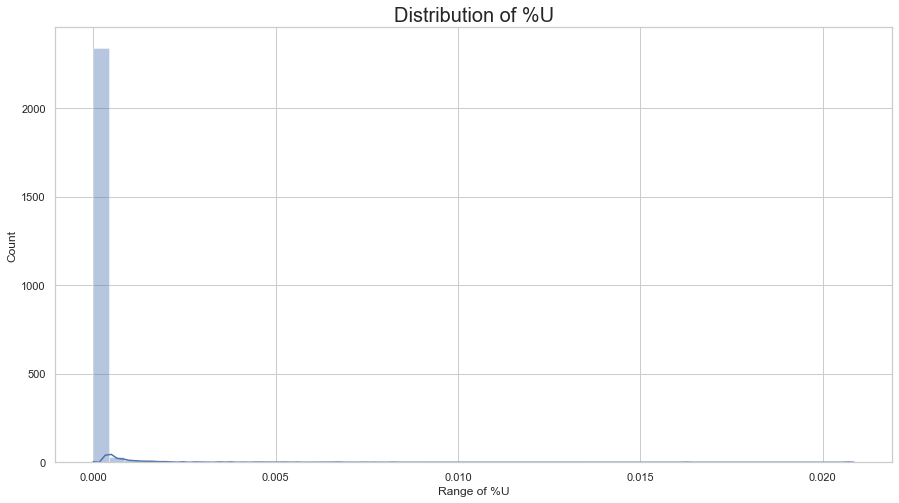

In [37]:
# Learning set % U histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data0['% U'])
plt.title('Distribution of %U', fontsize = 20)
plt.xlabel('Range of %U')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

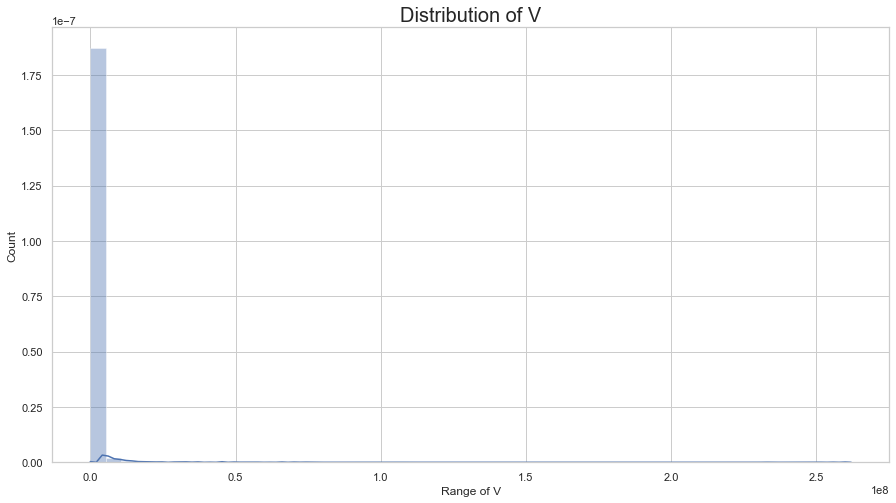

In [41]:
# Learning set V histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data0['V'])
plt.title('Distribution of V', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

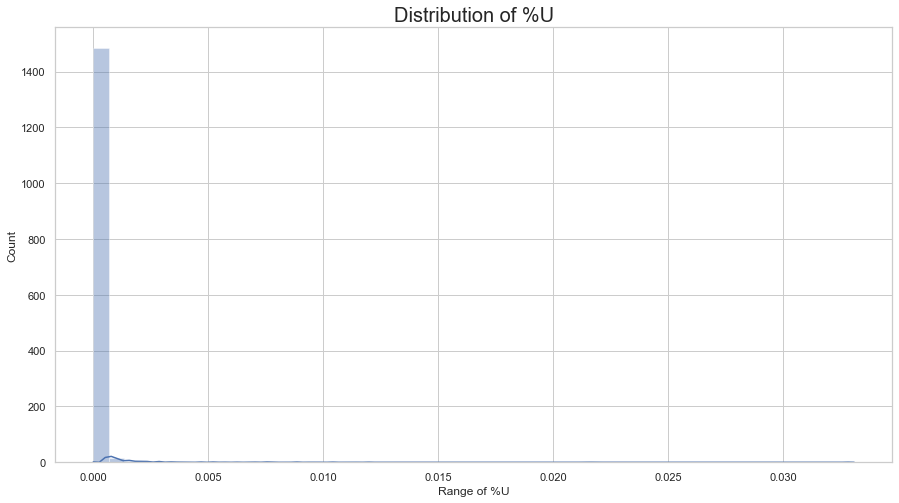

In [38]:
# Source 1 % U histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data1['% U'])
plt.title('Distribution of %U', fontsize = 20)
plt.xlabel('Range of %U')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

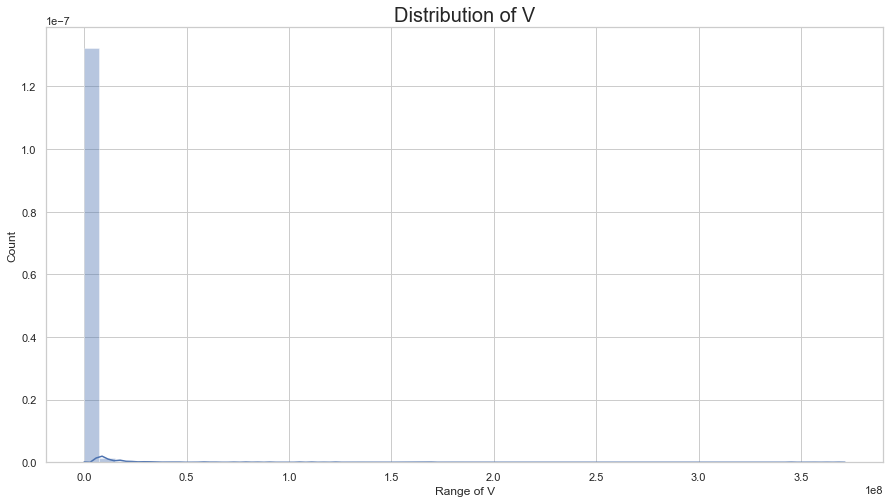

In [44]:
# Source 1 V histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data1['V'])
plt.title('Distribution of V', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

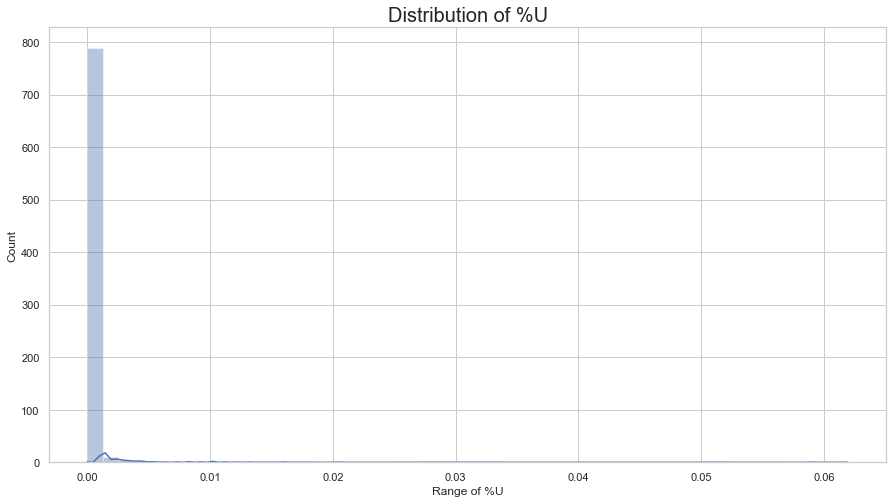

In [39]:
# Source 2 % U histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data2['% U'])
plt.title('Distribution of %U', fontsize = 20)
plt.xlabel('Range of %U')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

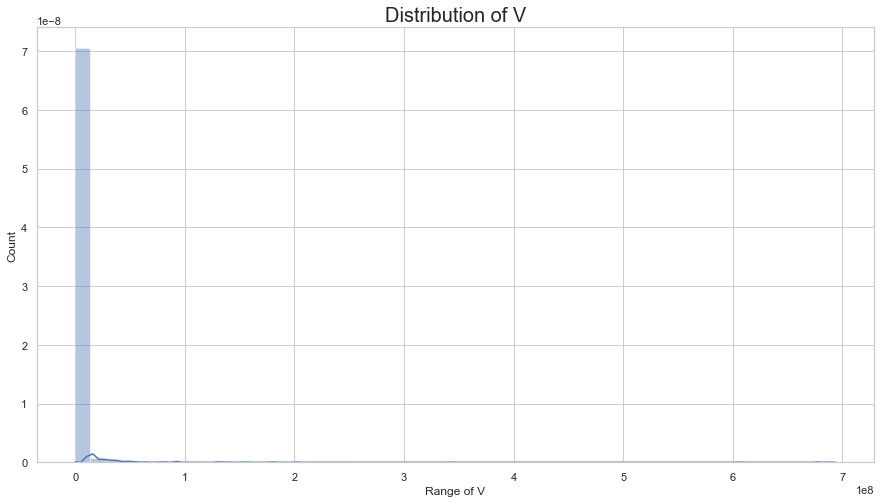

In [43]:
# Sourece 2 V histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data2['V'])
plt.title('Distribution of V', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

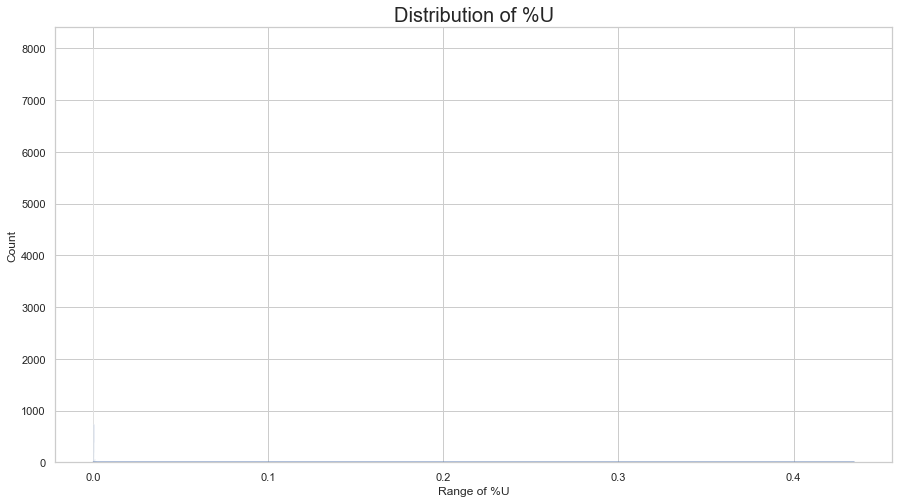

In [86]:
# Source 3 % U histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data3['% U'], np.arange(0, 0.01, 0.0001))
plt.title('Distribution of %U', fontsize = 20)
plt.xlabel('Range of %U')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

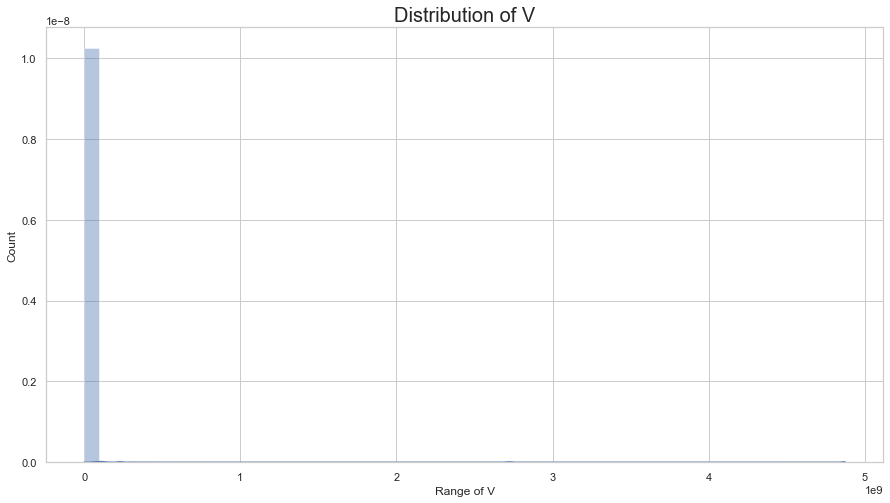

In [42]:
#  Source 3 V histogram
plt.subplot(1,1,1)
sns.set(style = 'whitegrid')
sns.distplot(data3['V'])
plt.title('Distribution of V', fontsize = 20)
plt.xlabel('Range of V')
plt.ylabel('Count')
plt.show()


# Most were under 0.001

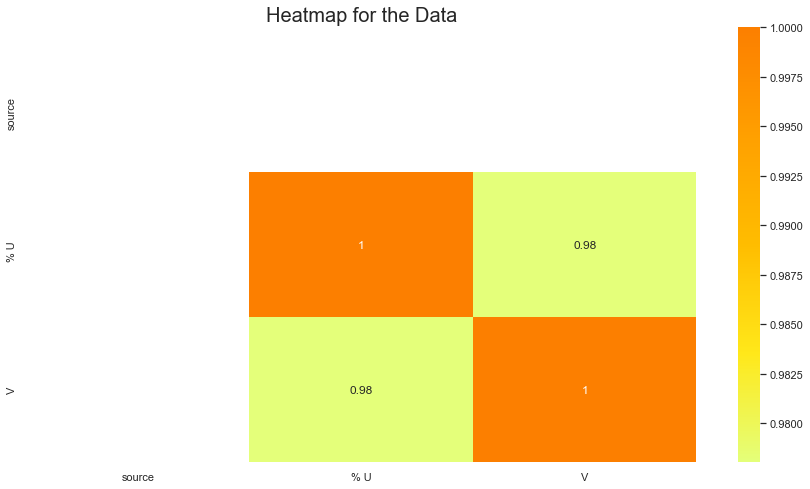

In [51]:
# Heatmap for learning set
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data0.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

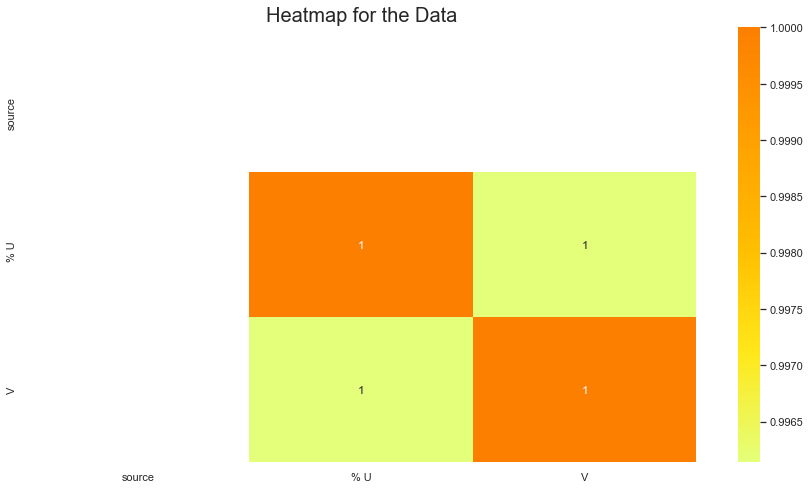

In [47]:
# Heatmap for sourece 1
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data1.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

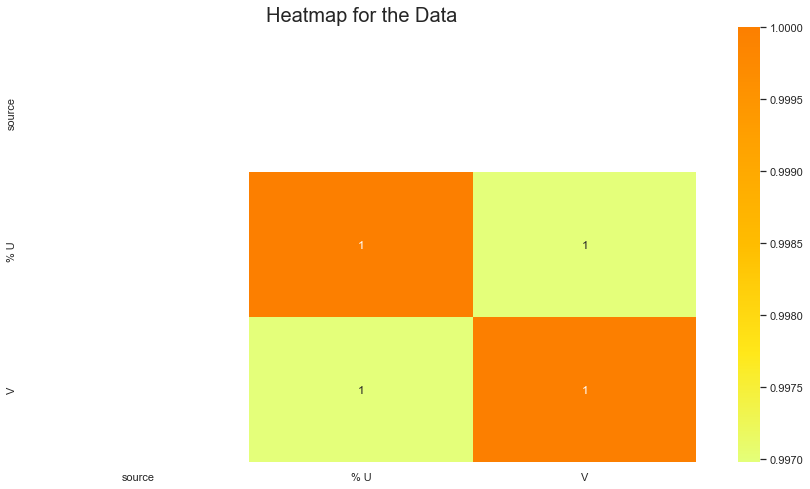

In [48]:
# Heatmap for source 2
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data2.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

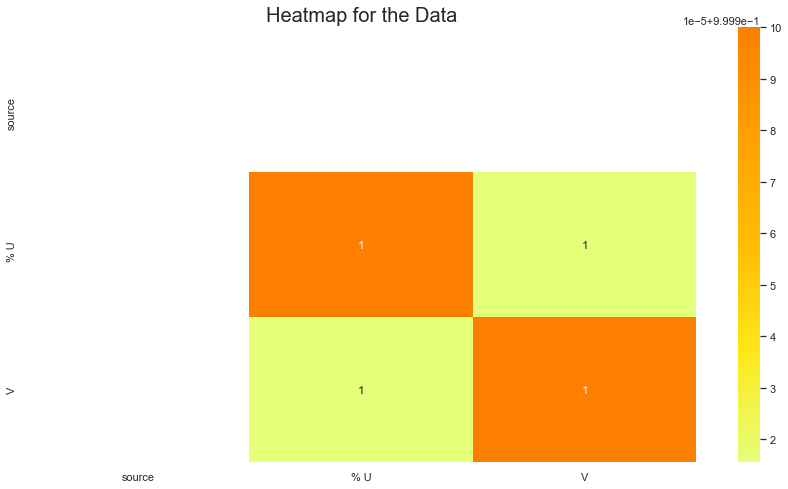

In [49]:
# Heatmap for source 3
plt.rcParams['figure.figsize'] = (15, 8)
sns.heatmap(data3.corr(), cmap = 'Wistia', annot = True)
plt.title('Heatmap for the Data', fontsize = 20)
plt.show()

In [ ]:
# We can see that in the learning set the correlation between V and %U is 98%, and in all the three sources the correlation is 1.

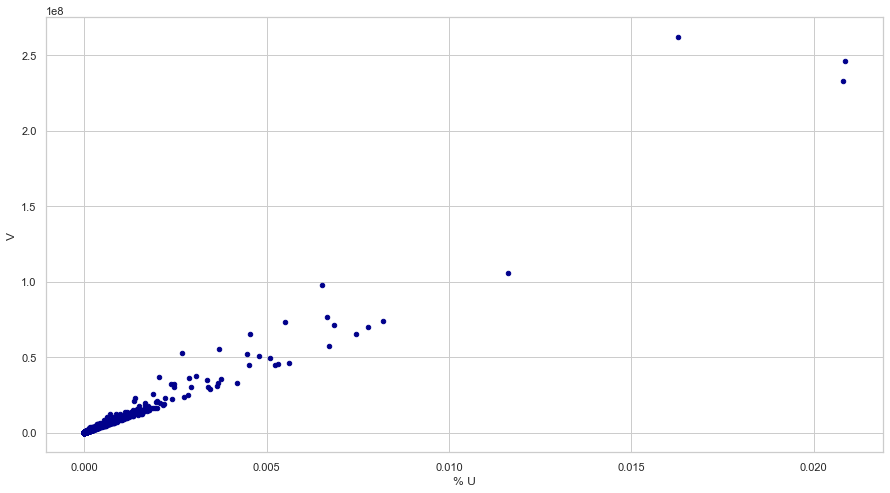

In [52]:
# Scatter plot of % U and V for the learning set
data0.plot.scatter(x='% U', y='V', c='DarkBlue')

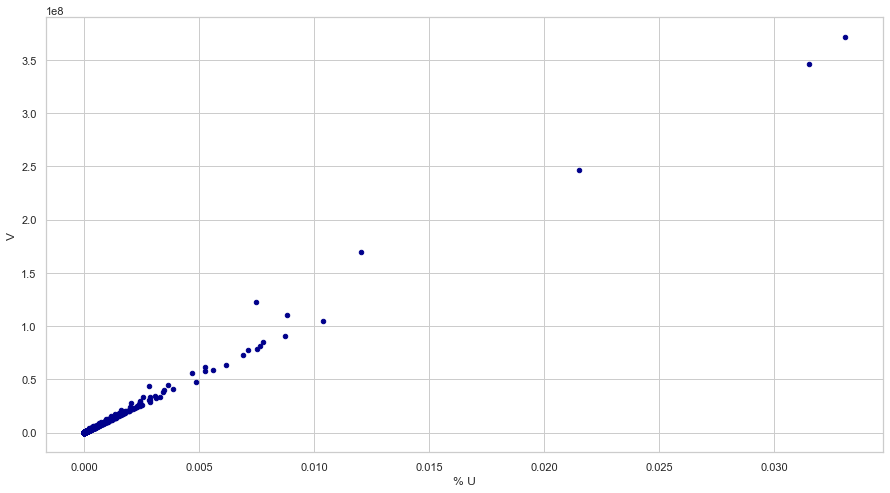

In [53]:
# Scatter plot of % U and V for source 1
data1.plot.scatter(x='% U', y='V', c='DarkBlue')

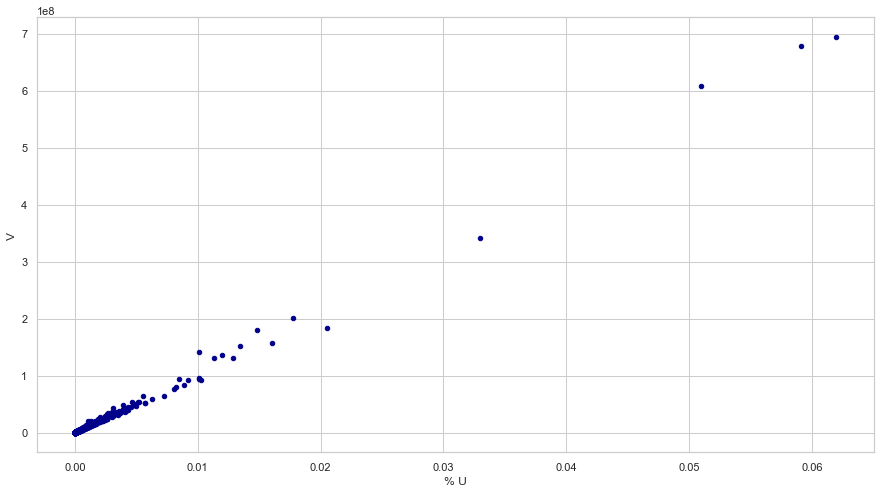

In [54]:
# Scatter plot of % U and V for source 2
data2.plot.scatter(x='% U', y='V', c='DarkBlue')

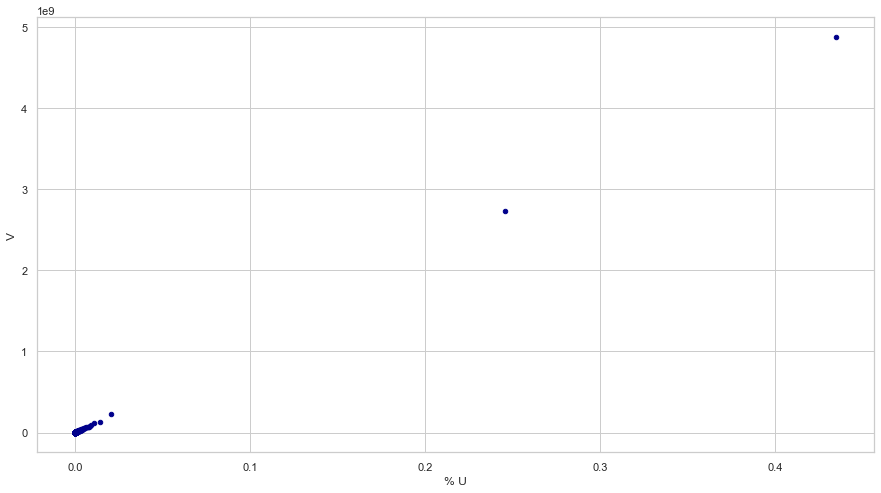

In [55]:
# Scatter plot of % U and V for source 3
data3.plot.scatter(x='% U', y='V', c='DarkBlue')

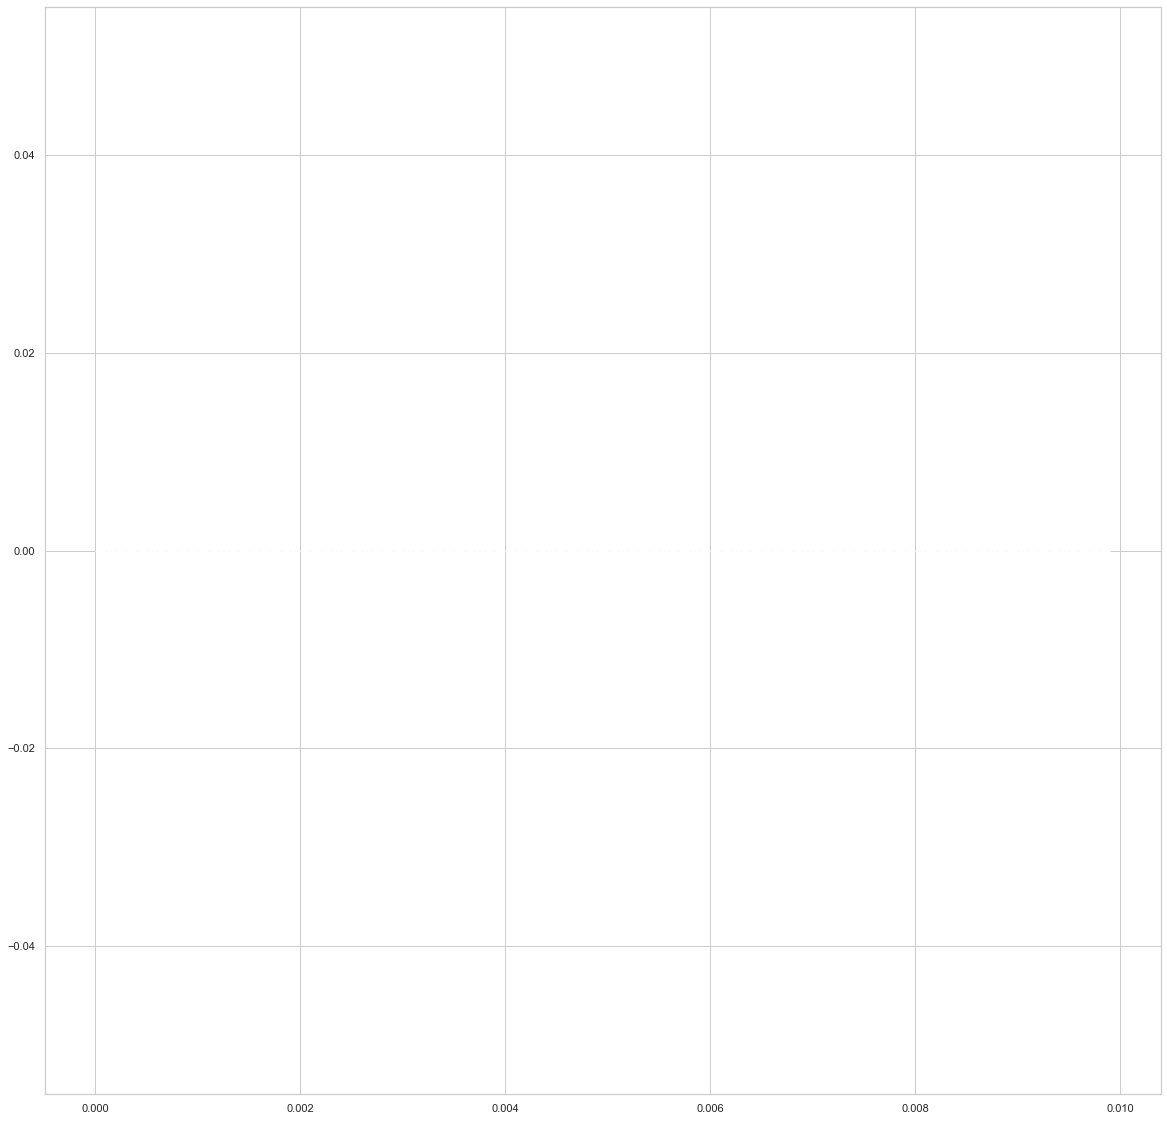

In [83]:
fig, axs = plt.subplots(1, 1, figsize=(20,20))
hist = axs.hist(data0['V'].to_numpy(), np.arange(0, 0.01, 0.0001)) #numpy to create bins over range
plt.show()

In [87]:
# Create dataframes from the learning set which contain only the sites which are in the compared source

data0_for1 = data0.loc[data0['site'].isin(data1['site'])]
data0_for2 = data0.loc[data0['site'].isin(data2['site'])]
data0_for3 = data0.loc[data0['site'].isin(data3['site'])]

In [132]:
# Display datasets

display(data0_for1)
display(data0_for2)
display(data0_for3)

# Verified that each df contains same sites as data1-3 and different V, %U (but the same as data0)

,source,site,% U,V
0,0,06880danwoog.com*,3.343111e-06,36280.0
1,0,0800-horoscope.com*,1.075026e-05,120690.0
2,0,10000boatnames.com*,5.871362e-07,6858.0
3,0,100bestvacations.com*,1.516845e-06,12891.0
4,0,100stuartstreet.com*,1.128228e-06,9758.0
...,...,...,...,...
9694,0,zurinstitute.com*,3.216422e-06,28788.0
9695,0,zvents.com*,9.387970e-05,740008.0
9696,0,zx6r.com*,4.094824e-06,57444.0
9697,0,zybez.net*,7.628508e-05,1237033.0


,source,site,% U,V
0,0,06880danwoog.com*,3.343111e-06,36280.0
1,0,0800-horoscope.com*,1.075026e-05,120690.0
6,0,1015store.com*,2.282332e-05,285488.0
7,0,101kgb.com*,9.015297e-06,76934.0
8,0,101science.com*,7.080000e-07,6502.0
...,...,...,...,...
9693,0,ztgd.com*,7.076418e-07,6144.0
9695,0,zvents.com*,9.387970e-05,740008.0
9696,0,zx6r.com*,4.094824e-06,57444.0
9697,0,zybez.net*,7.628508e-05,1237033.0


,source,site,% U,V
1,0,0800-horoscope.com*,1.075026e-05,120690.0
6,0,1015store.com*,2.282332e-05,285488.0
7,0,101kgb.com*,9.015297e-06,76934.0
8,0,101science.com*,7.080000e-07,6502.0
12,0,1035kissfm.com*,1.838593e-05,156960.0
...,...,...,...,...
9688,0,zonebourse.com*,9.435225e-07,7562.0
9689,0,zoochat.com*,2.586136e-06,32034.0
9695,0,zvents.com*,9.387970e-05,740008.0
9697,0,zybez.net*,7.628508e-05,1237033.0


In [ ]:
# Calculate metics:

In [115]:
# Difference between 'V' average
# Calculate for each source (1-3) the absulote value of the difference in 'V' mean between the learning set and the source

dif_avg_V_1 = abs(data0_for1['V'].mean() - data1['V'].mean())
dif_avg_V_2 = abs(data0_for2['V'].mean() - data2['V'].mean())
dif_avg_V_3 = abs(data0_for3['V'].mean() - data3['V'].mean())

display(dif_avg_V_1)
display(dif_avg_V_2)
display(dif_avg_V_3)

# Source 1 is the closests, then source 2 and then source 3

73448.75610726222

925200.6362900218

1972271.822261787

In [116]:
# Difference between '% U' average
# Calculate for each source (1-3) the absulote value of the difference in '% U' mean between the learning set and the source

dif_avg_U_1 = abs(data0_for1['% U'].mean() - data1['% U'].mean())
dif_avg_U_2 = abs(data0_for2['% U'].mean() - data2['% U'].mean())
dif_avg_U_3 = abs(data0_for3['% U'].mean() - data3['% U'].mean())

display(dif_avg_U_1)
display(dif_avg_U_2)
display(dif_avg_U_3)

# Source 1 is the closests, then source 2 and then source 3

2.420712881578239e-06

9.077667315628665e-05

0.00019037837290420952

In [121]:
# Difference between 'V' + % U' average
# Calculate for each source (1-3) the absulote value of the difference in '% U' mean between the learning set and the source

dif_avg_VplusU_1 = abs((data0_for1['V'] + data0_for1['% U']).mean() - (data1['V'] + data1['% U']).mean())
dif_avg_VplusU_2 = abs((data0_for2['V'] + data0_for2['% U']).mean() - (data2['V'] + data2['% U']).mean())
dif_avg_VplusU_3 = abs((data0_for3['V'] + data0_for3['% U']).mean() - (data3['V'] + data3['% U']).mean())

display(dif_avg_VplusU_1)
display(dif_avg_VplusU_2)
display(dif_avg_VplusU_3)

# Source 1 is the closests, then source 2 and then source 3

73448.75610968284

925200.6363807963

1972271.822452159

In [122]:
# Difference between 'V' * % U' average
# Calculate for each source (1-3) the absulote value of the difference in '% U' mean between the learning set and the source

dif_avg_VmulU_1 = abs((data0_for1['V'] * data0_for1['% U']).mean() - (data1['V'] * data1['% U']).mean())
dif_avg_VmulU_2 = abs((data0_for2['V'] * data0_for2['% U']).mean() - (data2['V'] * data2['% U']).mean())
dif_avg_VmulU_3 = abs((data0_for3['V'] * data0_for3['% U']).mean() - (data3['V'] * data3['% U']).mean())

display(dif_avg_VmulU_1)
display(dif_avg_VmulU_2)
display(dif_avg_VmulU_3)

# Source 1 is the closests, then source 2 and then source 3

2092.0395656593046

20720.82334546019

814166.526932614

In [123]:
# Difference between 'V' median
# Calculate for each source (1-3) the absulote value of the difference in 'V' median between the learning set and the source

dif_median_V_1 = abs(data0_for1['V'].median() - data1['V'].median())
dif_median_V_2 = abs(data0_for2['V'].median() - data2['V'].median())
dif_median_V_3 = abs(data0_for3['V'].median() - data3['V'].median())

display(dif_median_V_1)
display(dif_median_V_2)
display(dif_median_V_3)

# Source 1 is the closests, then source 2 and then source 3

418.95636799045315

64617.17701863899

36417.73843795952

In [124]:
# Difference between '%U' median
# Calculate for each source (1-3) the absulote value of the difference in 'V' median between the learning set and the source

dif_median_U_1 = abs(data0_for1['% U'].median() - data1['% U'].median())
dif_median_U_2 = abs(data0_for2['% U'].median() - data2['% U'].median())
dif_median_U_3 = abs(data0_for3['% U'].median() - data3['% U'].median())

display(dif_median_U_1)
display(dif_median_U_2)
display(dif_median_U_3)

# Source 1 is the closests, then source 2 and then source 3

4.462013412404902e-07

7.387768757546161e-06

1.2603166298850526e-06

In [125]:
# Difference between 'V' + % U' median
# Calculate for each source (1-3) the absulote value of the difference in '% U' median between the learning set and the source

dif_median_VplusU_1 = abs((data0_for1['V'] + data0_for1['% U']).median() - (data1['V'] + data1['% U']).median())
dif_median_VplusU_2 = abs((data0_for2['V'] + data0_for2['% U']).median() - (data2['V'] + data2['% U']).median())
dif_median_VplusU_3 = abs((data0_for3['V'] + data0_for3['% U']).median() - (data3['V'] + data3['% U']).median())

display(dif_median_VplusU_1)
display(dif_median_VplusU_2)
display(dif_median_VplusU_3)

# Different result-
# Source 1 is the closests, then source 3 and then source 2

418.95636789705895

64617.17702590363

36417.7384413722

In [126]:
# Difference between 'V' * % U' median
# Calculate for each source (1-3) the absulote value of the difference in '% U' median between the learning set and the source

dif_median_VmulU_1 = abs((data0_for1['V'] * data0_for1['% U']).median() - (data1['V'] * data1['% U']).median())
dif_median_VmulU_2 = abs((data0_for2['V'] * data0_for2['% U']).median() - (data2['V'] * data2['% U']).median())
dif_median_VmulU_3 = abs((data0_for3['V'] * data0_for3['% U']).median() - (data3['V'] * data3['% U']).median())

display(dif_median_VmulU_1)
display(dif_median_VmulU_2)
display(dif_median_VmulU_3)

# Different result-
# Source 1 is the closests, then source 3 and then source 2

0.026807071011930583

1.5579204200814116

0.8416219753024361

In [127]:
# Difference between 'V' std
# Calculate for each source (1-3) the absulote value of the difference in 'V' std between the learning set and the source

dif_std_V_1 = abs(data0_for1['V'].std() - data1['V'].std())
dif_std_V_2 = abs(data0_for2['V'].std() - data2['V'].std())
dif_std_V_3 = abs(data0_for3['V'].std() - data3['V'].std())

display(dif_std_V_1)
display(dif_std_V_2)
display(dif_std_V_3)

# Source 1 is the closests, then source 2 and then source 3

1655504.0769965108

9802798.606539484

86557180.36979736

In [128]:
# Difference between '% U' std
# Calculate for each source (1-3) the absulote value of the difference in '% U' std between the learning set and the source

dif_std_U_1 = abs(data0_for1['% U'].std() - data1['% U'].std())
dif_std_U_2 = abs(data0_for2['% U'].std() - data2['% U'].std())
dif_std_U_3 = abs(data0_for3['% U'].std() - data3['% U'].std())

display(dif_std_U_1)
display(dif_std_U_2)
display(dif_std_U_3)

# Source 1 is the closests, then source 2 and then source 3

0.00015716506787041406

0.0009035546605683984

0.0077689620403086565

In [129]:
# Difference between 'V' + % U' std
# Calculate for each source (1-3) the absulote value of the difference in '% U' std between the learning set and the source

dif_std_VplusU_1 = abs((data0_for1['V'] + data0_for1['% U']).std() - (data1['V'] + data1['% U']).std())
dif_std_VplusU_2 = abs((data0_for2['V'] + data0_for2['% U']).std() - (data2['V'] + data2['% U']).std())
dif_std_VplusU_3 = abs((data0_for3['V'] + data0_for3['% U']).std() - (data3['V'] + data3['% U']).std())

display(dif_std_VplusU_1)
display(dif_std_VplusU_2)
display(dif_std_VplusU_3)

# Different result-
# Source 1 is the closests, then source 3 and then source 2

1655504.0771623682

9802798.6074512

86557180.37758331

In [130]:
# Difference between 'V' * % U' std
# Calculate for each source (1-3) the absulote value of the difference in '% U' mean between the learning set and the source

dif_std_VmulU_1 = abs((data0_for1['V'] * data0_for1['% U']).std() - (data1['V'] * data1['% U']).std())
dif_std_VmulU_2 = abs((data0_for2['V'] * data0_for2['% U']).std() - (data2['V'] * data2['% U']).std())
dif_std_VmulU_3 = abs((data0_for3['V'] * data0_for3['% U']).std() - (data3['V'] * data3['% U']).std())

display(dif_std_VmulU_1)
display(dif_std_VmulU_2)
display(dif_std_VmulU_3)

# Source 1 is the closests, then source 2 and then source 3

98209.28580637735

721815.0913557182

37865459.92777424

In [100]:
data1['V'].mean()

805473.2164695299

In [101]:
data0['V'].mean()

649315.5827404887